In [1]:
%%capture
!pip install geemap earthengine-api
!pip install rasterio matplotlib numpy

In [2]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import rasterio

In [3]:
try:
    ee.Authenticate()
    ee.Initialize(project='ee-sandorburian')
    print("✓ Earth Engine initialized successfully")
except Exception as e:
    print(f"Error: {e}")
    print("Run: ee.Authenticate() first")

✓ Earth Engine initialized successfully


In [4]:
# Example regions
## Greece
greece = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017") \
           .filter(ee.Filter.eq('country_na', 'Greece'))
greece_boundary = greece.geometry()

## Athens
athens_region = ee.Geometry.Rectangle([23.5, 37.8, 24.1, 38.2])

## Demo
test_region   = ee.Geometry.Rectangle([40.7, 26.4, 24.1, 38.2])

## Bushfire in 2023
burn_test_region = ee.Geometry.Rectangle([
    25.419968028200316, 40.79514759494151,  # xmin, ymin (SW corner)
    26.305033189080742, 41.2277677156888    # xmax, ymax (NE corner)
])

In [5]:
burn_region_fire_2023 = ee.Geometry.Rectangle([
    25.419968028200316, 40.79514759494151,  # xmin, ymin (SW corner)
    26.305033189080742, 41.2277677156888    # xmax, ymax (NE corner)
])

burn_region_fire_2011 = ee.Geometry.Rectangle([
    40.9439, 26.0201,  # xmin, ymin (SW corner)
    41.0649, 26.2340    # xmax, ymax (NE corner)
])

burn_region_fire_2011

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              40.9439,
              26.234
            ],
            [
              40.9439,
              26.0201
            ],
            [
              41.0649,
              26.0201
            ],
            [
              41.0649,
              26.234
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [6]:
def Sentinel2_Satellite_Imagery(area_of_interest=burn_region_fire_2023, start_date = '2023-07-13', end_date = '2023-08-13', cloud_threshold = 10):
  '''
  Get Sentinel-2 Surface Reflectance collection
  arguments:
  - area_of_interest: ee.Geometry
  - start_date: yyyy-mm-dd
  - end_date: yyyy-mm-dd
  - cloud_threshold: percentage of cloud on the image, value from 0 to 100

  return: Sentinel-2 Surface Reflectance collection or if there is no image found return None
  '''
  # Get Sentinel-2 Surface Reflectance collection
  sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                .filterDate(start_date, end_date) \
                .filterBounds(area_of_interest) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_threshold))

  # Check how many images we found
  image_count = sentinel2.size().getInfo()
  print(f"Found {image_count} Sentinel-2 images for the specified period")

  # return the images
  if image_count == 0:
      print("⚠️  No images found. Try expanding date range or increasing cloud threshold.")
      return None
  else:
    return sentinel2

# Test the function with default values
sentinel2 = Sentinel2_Satellite_Imagery()

Found 15 Sentinel-2 images for the specified period


In [7]:
def Landsat_LE7_C2_T1(area_of_interest=burn_region_fire_2011, start_date = '2011-08-24', end_date = '2011-10-24'):
  '''
  Get USGS Landsat 7 Level 2, Collection 2, Tier 1 Surface Reflectance collection
  arguments:
  - area_of_interest: ee.Geometry
  - start_date: yyyy-mm-dd
  - end_date: yyyy-mm-dd

  return: Landsat Surface Reflectance collection or if there is no image found return None
  '''
  # Get Landsat Surface Reflectance collection
  landsat = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
                .filterDate(start_date, end_date) \
                .filterBounds(area_of_interest)

  # Check how many images we found
  image_count = landsat.size().getInfo()
  print(f"Found {image_count} USGS Landsat 7 Level 2, Collection 2, Tier 1 images for the specified period")

  if image_count == 0:
      print("⚠️  No images found. Try expanding date range or increasing cloud threshold.")
      return None
  else:
    return landsat

# Test the function with default values
landsat = Landsat_LE7_C2_T1()

Found 6 USGS Landsat 7 Level 2, Collection 2, Tier 1 images for the specified period


In [8]:
def calculate_ndvi_on_Sentinel2(image):
    """
    Calculate NDVI for a Sentinel-2 image
    B4 = Red band, B8 = NIR band
    """
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

def calculate_median_ndvi_on_Sentinel2():
    """
    Calculate the median NDVI for a collection of Sentinel-2 images
    """
    try:
      # Apply NDVI calculation to all images
      ndvi_collection = sentinel2.map(calculate_ndvi_on_Sentinel2)

      # Create median composite to reduce cloud effects and seasonal variation
      median_ndvi = ndvi_collection.select('NDVI').median().clip(burn_region_fire_2023)

      print("✓ NDVI calculated successfully")
      return median_ndvi
    except Exception as e:
      print(f"⚠️ An error occurred while calculating NDVI: {e}")
      return None

# Calculate median NDVI
median_ndvi_sentinel2 = calculate_median_ndvi_on_Sentinel2()
median_ndvi_sentinel2

✓ NDVI calculated successfully


In [9]:
def show_interactive_map_with_ndvi_layer(median_ndvi, interested_area = burn_region_fire_2023):
  '''
  Display an interactive map with NDVI layer
  arguments:
  - median_ndvi: ee.Image
  - interested_area: ee.Geometry
  '''

  # Define NDVI visualization parameters
  ndvi_params = {
      'min': -0.2,
      'max': 0.8,
      'palette': [
          '#d73027',  # Red (low NDVI - bare soil/water)
          '#f46d43',  # Orange
          '#fdae61',  # Light orange
          '#fee08b',  # Yellow
          '#e6f598',  # Light green
          '#abdda4',  # Green
          '#66c2a5',  # Dark green
          '#3288bd'   # Blue-green (high NDVI - dense vegetation)
      ]
  }

  Map = geemap.Map(center=[39.0, 22.0], zoom=6)
  # Add NDVI layer to map
  Map.addLayer(median_ndvi, ndvi_params, 'NDVI Layer')

  # Add Greece boundary (optional)
  Map.addLayer(greece_boundary, {'color': 'red', 'width': 2}, 'Greece Boundary', False)

  # Center map on area of interest
  Map.centerObject(interested_area, 8)

  # Display map
  return Map


# Demo usage of this visualisation function
map = show_interactive_map_with_ndvi_layer(median_ndvi_sentinel2)
map

Map(center=[41.012067138890096, 25.862500608640715], controls=(WidgetControl(options=['position', 'transparent…

In [10]:
def NDVI_interretation(mean_ndvi):
  #mean_ndvi = ndvi_stats['NDVI_mean']
  if mean_ndvi > 0.6:
      interpretation = "Dense, healthy vegetation"
  elif mean_ndvi > 0.3:
      interpretation = "Moderate vegetation cover"
  elif mean_ndvi > 0:
      interpretation = "Sparse vegetation"
  else:
      interpretation = "Predominantly non-vegetated areas"
  print(f"🌱 Interpretation: {interpretation}")
  return interpretation

#NDVI_interretation(ndvi_stats['NDVI_mean'])

In [11]:
def get_NDVI_values_as_NumPy_array(interested_area=burn_region_fire_2023, ndvi_median=median_ndvi_sentinel2, scale=100):
  """
  Get NDVI values as an array from the an image.

  arguments:
  - interested_area: ee.Geometry
  - ndvi_median: ee.Image
  - scale: scale of the image, default is 100, 30 is the minimum
  return: array of NDVI values or NaN if empty
  """
  try:
    # Extract NDVI pixel values as a NumPy array
    region = interested_area.getInfo()['coordinates']
    ndvi_array = geemap.ee_to_numpy(ndvi_median, region=interested_area, bands=['NDVI'], scale=scale)

    # Flatten the array and remove NaN values
    ndvi_flat = ndvi_array.flatten()
    ndvi_flat = ndvi_flat[~np.isnan(ndvi_flat)]
    print("✓ NDVI values extracted successfully")
    return ndvi_flat
  except Exception as e:
    print(f"⚠️ An error occurred while calculating NDVI statistics: {e}")
    return None

# Example run
ndvi_flat = get_NDVI_values_as_NumPy_array()
print(ndvi_flat)


✓ NDVI values extracted successfully
[0.8141994  0.87271917 0.8814499  ... 0.78166515 0.762056   0.7822288 ]


In [12]:
def calculate_NDVI_Statistics(interested_area=burn_region_fire_2023, ndvi_median=median_ndvi_sentinel2, scale=100):
    """
    Calculate NDVI statistics for an image using Earth Engine's reduceRegion.

    arguments:
    - interested_area: ee.Geometry
    - ndvi_median: ee.Image
    - scale: scale of the image, default is 100

    return:
    - ndvi_stats: dictionary containing NDVI statistics (min, max, mean, std, count); None if an error occurs.
    """
    try:
        # Use reduceRegion to calculate statistics directly on the Earth Engine image
        stats = ndvi_median.reduceRegion(
            reducer=ee.Reducer.min().combine(ee.Reducer.max(), '', True).combine(ee.Reducer.mean(), '', True).combine(ee.Reducer.stdDev(), '', True).combine(ee.Reducer.count(), '', True),
            geometry=interested_area,
            scale=scale,
            maxPixels=1e13 # Increase maxPixels if the region is very large
        )

        # Get the statistics as a dictionary
        ndvi_stats = stats.getInfo()

        # Rename keys for clarity
        formatted_stats = {
            'NDVI_min': ndvi_stats.get('NDVI_min'),
            'NDVI_max': ndvi_stats.get('NDVI_max'),
            'NDVI_mean': ndvi_stats.get('NDVI_mean'),
            'NDVI_std': ndvi_stats.get('NDVI_std'),
            'NDVI_count': ndvi_stats.get('NDVI_count') # Number of non-masked pixels
        }

        print("📊 NDVI Statistics for the area calculated!")
        return formatted_stats
    except Exception as e:
        print(f"⚠️ An error occurred while calculating NDVI statistics: {e}")
        return None

# Example run (using the original median_ndvi_sentinel2 for comparison)
# ndvi_stats_original = calculate_NDVI_Statistics(ndvi_median=median_ndvi_sentinel2)
# print("Original NDVI Stats:", ndvi_stats_original)

# Example run with the masked image
# ndvi_stats_masked = calculate_NDVI_Statistics(ndvi_median=median_ndvi_masked)
# print("Masked NDVI Stats:", ndvi_stats_masked)

In [13]:
def plot_NDVI_distribution(interested_area=burn_region_fire_2023, ndvi_median=median_ndvi_sentinel2, scale=100):
    ndvi_flat = get_NDVI_values_as_NumPy_array(interested_area, ndvi_median, scale)

    if ndvi_flat is not None:
        print(f"Number of non-masked pixels for plotting: {len(ndvi_flat)}")
        # Plot Seaborn boxplot
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=ndvi_flat, color='green')
        plt.title('NDVI Distribution (Boxplot)')
        plt.xlabel('NDVI Value')
        plt.show()
    else:
        print("⚠️ Could not get NDVI values as NumPy array for plotting.")

# Example run with the original median_ndvi_sentinel2
# print("Plot for original NDVI:")
# plot_NDVI_distribution(ndvi_median=median_ndvi_sentinel2)

# Example run with the masked image
# print("\nPlot for masked NDVI:")
# plot_NDVI_distribution(ndvi_median=median_ndvi_masked)

In [14]:
def create_water_mask(area_of_interest):
  """
  Creates a water mask using the JRC Global Surface Water dataset.

  arguments:
  - area_of_interest: ee.Geometry

  return: An ee.Image representing the water mask (1 for water, 0 for land).
  """
  # Load the JRC Global Surface Water dataset
  jrc_dataset = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')

  # Select the occurrence band, which represents the frequency of water presence
  water_occurrence = jrc_dataset.select('occurrence')

  # Create a binary water mask (e.g., where occurrence is greater than 10%)
  water_mask = water_occurrence.gt(10).rename('water_mask')

  return water_mask

def mask_water_from_image(image, water_mask):
  """
  Masks out water pixels from an image using a water mask.

  arguments:
  - image: ee.Image (e.g., NDVI image)
  - water_mask: ee.Image (binary mask, 1 for water, 0 for land)

  return: The input image with water pixels masked.
  """
  # Mask the image where the water mask is 1 (water)
  masked_image = image.updateMask(water_mask.eq(0))

  return masked_image

# Example usage:
# 1. Create the water mask for your area of interest
#water_mask = create_water_mask(burn_region_fire_2023)

# 2. Apply the water mask to your median NDVI image
#median_ndvi_no_water = mask_water_from_image(median_ndvi_sentinel2, water_mask)

# Now median_ndvi_no_water is your NDVI image with water pixels masked out.
# You can display or analyze this new image.

In [15]:
def create_black_mask_from_false_color(image, band_names=['B8', 'B4', 'B3'], threshold=0.05):
  """
  Creates a mask based on low values in specified bands (representing black in false color).

  arguments:
  - image: ee.Image (e.g., a Sentinel-2 image)
  - band_names: List of band names to use for the false color composite (default is NIR, Red, Green for S2)
  - threshold: The maximum value in any of the specified bands for a pixel to be masked (considered "black").

  return: An ee.Image representing the mask (1 for areas considered "black", 0 otherwise).
  """
  # Select the specified bands
  false_color_bands = image.select(band_names)

  # Create a mask where all selected bands are below the threshold
  # Use reduce('and') to ensure all bands meet the criteria
  black_mask = false_color_bands.reduce('min').lt(threshold).rename('black_mask')

  return black_mask

# Example usage (assuming 'sentinel2' is your Sentinel-2 image collection or a single image):
# You would typically apply this to a single image or a composite image.
# Let's get a single image from the collection used before for demonstration
if sentinel2 is not None:
    first_image = sentinel2.first()
    if first_image is not None:
        black_mask = create_black_mask_from_false_color(first_image)
        print("✓ Black mask created successfully from a Sentinel-2 image.")
        # You can now use this black_mask to mask other images
        #masked_image = image_to_mask.updateMask(black_mask.eq(0)) # Mask out the black areas
    else:
        print("⚠️ Sentinel-2 collection is empty, cannot create black mask.")
else:
    print("⚠️ Sentinel-2 collection is not available, cannot create black mask.")

✓ Black mask created successfully from a Sentinel-2 image.


In [16]:
black_mask = create_black_mask_from_false_color(first_image)
masked_image = first_image.updateMask(black_mask.eq(0))
median_ndvi_no_water_based_on_false_color = mask_water_from_image(median_ndvi_sentinel2, black_mask)
map_without_water_based_false_color_mask = show_interactive_map_with_ndvi_layer(median_ndvi_no_water_based_on_false_color)
map_without_water_based_false_color_mask
#masked_image

Map(center=[41.012067138890096, 25.862500608640715], controls=(WidgetControl(options=['position', 'transparent…

In [17]:
def calculate_ndwi(image):
  """
  Calculate NDWI for a Sentinel-2 image.
  NDWI = (Green - NIR) / (Green + NIR)
  B3 = Green band, B8 = NIR band
  """
  # Select Green (B3) and NIR (B8) bands
  green = image.select('B3')
  nir = image.select('B8')

  # Calculate NDWI
  ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')

  return image.addBands(ndwi)

def create_water_mask_from_ndwi(ndwi_image, threshold=0.0):
  """
  Creates a water mask based on an NDWI threshold.

  arguments:
  - ndwi_image: ee.Image with an 'NDWI' band
  - threshold: The NDWI value above which pixels are considered water (default is 0.0).

  return: An ee.Image representing the water mask (1 for water, 0 for land).
  """
  # Create a binary water mask where NDWI is greater than the threshold
  water_mask = ndwi_image.select('NDWI').gt(threshold).rename('water_mask_ndwi')

  return water_mask

# Example Usage:
# Assuming 'first_image' is a Sentinel-2 image from your collection
if first_image is not None:
    # 1. Calculate NDWI
    image_with_ndwi = calculate_ndwi(first_image)

    # 2. Create water mask from NDWI
    water_mask_ndwi = create_water_mask_from_ndwi(image_with_ndwi)

    print("✓ NDWI calculated and water mask created successfully using NDWI.")

    # You can now use water_mask_ndwi to mask your NDVI image or other images
    # median_ndvi_no_water_ndwi = median_ndvi_sentinel2.updateMask(water_mask_ndwi.eq(0))

    median_ndvi_no_water_based_on_false_color = mask_water_from_image(median_ndvi_sentinel2, water_mask_ndwi)
    map_without_water_based_false_color_mask = show_interactive_map_with_ndvi_layer(median_ndvi_no_water_based_on_false_color)
    map_without_water_based_false_color_mask

else:
    print("⚠️ Sentinel-2 image is not available to calculate NDWI and create water mask.")

✓ NDWI calculated and water mask created successfully using NDWI.


In [18]:
image_with_ndwi = calculate_ndwi(first_image)

# 2. Create water mask from NDWI
water_mask_ndwi = create_water_mask_from_ndwi(image_with_ndwi)

print("✓ NDWI calculated and water mask created successfully using NDWI.")

# median_ndvi_no_water_ndwi = median_ndvi_sentinel2.updateMask(water_mask_ndwi.eq(0))

median_ndvi_no_water_based_on_false_color = mask_water_from_image(median_ndvi_sentinel2, water_mask_ndwi)
map_without_water_based_false_color_mask = show_interactive_map_with_ndvi_layer(median_ndvi_no_water_based_on_false_color)
map_without_water_based_false_color_mask

✓ NDWI calculated and water mask created successfully using NDWI.


Map(center=[41.012067138890096, 25.862500608640715], controls=(WidgetControl(options=['position', 'transparent…

In [19]:
def calculate_ndbi(image):
  """
  Calculate NDBI for a Sentinel-2 image.
  NDBI = (SWIR1 - NIR) / (SWIR1 + NIR)
  B11 = SWIR1 band, B8 = NIR band
  """
  # Select SWIR1 (B11) and NIR (B8) bands
  swir1 = image.select('B11')
  nir = image.select('B8')

  # Calculate NDBI
  ndbi = swir1.subtract(nir).divide(swir1.add(nir)).rename('NDBI')

  return image.addBands(ndbi)

def create_urban_mask_from_ndbi(ndbi_image, threshold=0.0):
  """
  Creates an urban mask based on an NDBI threshold.

  arguments:
  - ndbi_image: ee.Image with an 'NDBI' band
  - threshold: The NDBI value above which pixels are considered urban (default is 0.0).
               Urban areas typically have higher NDBI values than vegetation or water.

  return: An ee.Image representing the urban mask (1 for urban, 0 for non-urban).
  """
  # Create a binary urban mask where NDBI is greater than the threshold
  urban_mask = ndbi_image.select('NDBI').gt(threshold).rename('urban_mask_ndbi')

  return urban_mask

# Example Usage (assuming 'first_image' is a Sentinel-2 image):
if first_image is not None:
    # 1. Calculate NDBI
    image_with_ndbi = calculate_ndbi(first_image)

    # 2. Create urban mask from NDBI
    # You might need to adjust the threshold based on your area and image characteristics
    urban_mask_ndbi = create_urban_mask_from_ndbi(image_with_ndbi, threshold=0.1) # Example threshold

    print("✓ NDBI calculated and urban mask created successfully using NDBI.")

    # You can now use urban_mask_ndbi to mask your NDVI image or other images
    # median_ndvi_no_urban = median_ndvi_sentinel2.updateMask(urban_mask_ndbi.eq(0))

else:
    print("⚠️ Sentinel-2 image is not available to calculate NDBI and create urban mask.")

✓ NDBI calculated and urban mask created successfully using NDBI.


In [20]:
image_with_ndwi = calculate_ndwi(first_image)

# 2. Create water mask from NDWI
water_mask_ndwi = create_water_mask_from_ndwi(image_with_ndwi)

image_with_ndbi = calculate_ndbi(first_image)

# 2. Create urban mask from NDBI
# You might need to adjust the threshold based on your area and image characteristics
urban_mask_ndbi = create_urban_mask_from_ndbi(image_with_ndbi, threshold=0.1) # Example threshold

# median_ndvi_no_water_ndwi = median_ndvi_sentinel2.updateMask(water_mask_ndwi.eq(0))

median_ndvi_no_water_based_on_false_color = mask_water_from_image(median_ndvi_sentinel2, urban_mask_ndbi)
map_without_city_based_false_color_mask = show_interactive_map_with_ndvi_layer(median_ndvi_no_water_based_on_false_color)
map_without_city_based_false_color_mask

Map(center=[41.012067138890096, 25.862500608640715], controls=(WidgetControl(options=['position', 'transparent…

In [21]:
# Calculate NDWI and create water mask
image_with_ndwi = calculate_ndwi(first_image)
water_mask_ndwi = create_water_mask_from_ndwi(image_with_ndwi)

# Calculate NDBI and create urban mask
image_with_ndbi = calculate_ndbi(first_image)
# You might need to adjust the threshold based on your area and image characteristics
urban_mask_ndbi = create_urban_mask_from_ndbi(image_with_ndbi, threshold=0.1) # Example threshold

# Combine the masks: Add the water mask and urban mask.
# Pixels that are either water (mask_ndwi=1) or urban (urban_mask_ndbi=1) will have a value >= 1.
# We then create a combined mask where the value is 1 if it's either water or urban.
combined_mask = water_mask_ndwi.add(urban_mask_ndbi).gt(0).rename('combined_mask')

# Apply the combined mask to the median NDVI image
# We update the mask where combined_mask is 0 (meaning it's neither water nor urban)
median_ndvi_combined_masked = median_ndvi_sentinel2.updateMask(combined_mask.eq(0))

# Display the masked NDVI image on a map
map_masked_ndvi = show_interactive_map_with_ndvi_layer(median_ndvi_combined_masked)
map_masked_ndvi

Map(center=[41.012067138890096, 25.862500608640715], controls=(WidgetControl(options=['position', 'transparent…

# Before filtering

📊 NDVI Statistics for the area calculated!
{'NDVI_min': -0.3574053645133972, 'NDVI_max': 0.9343518018722534, 'NDVI_mean': 0.513977295657108, 'NDVI_std': None, 'NDVI_count': 475694}
✓ NDVI values extracted successfully
Number of non-masked pixels for plotting: 477224


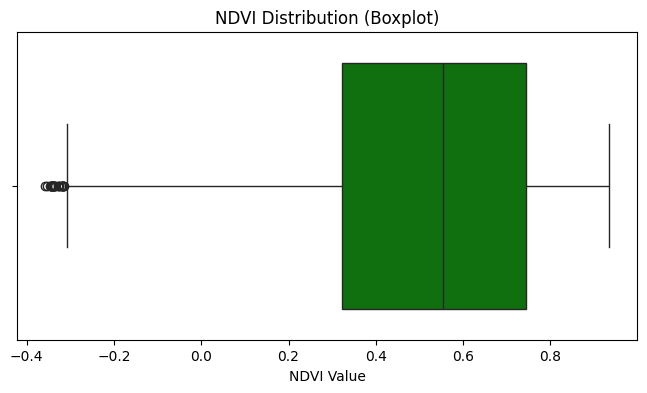

In [22]:
ndvi_stats = calculate_NDVI_Statistics()
print(ndvi_stats)
plot_NDVI_distribution()

# After filtering

--- NDVI Statistics and Distribution After Masking ---
📊 NDVI Statistics for the area calculated!
{'NDVI_min': -0.07566462457180023, 'NDVI_max': 0.9093047976493835, 'NDVI_mean': 0.5913733166633921, 'NDVI_std': None, 'NDVI_count': 200165}

--- NDVI Distribution Plot After Masking ---
✓ NDVI values extracted successfully
Number of non-masked pixels for plotting: 477224


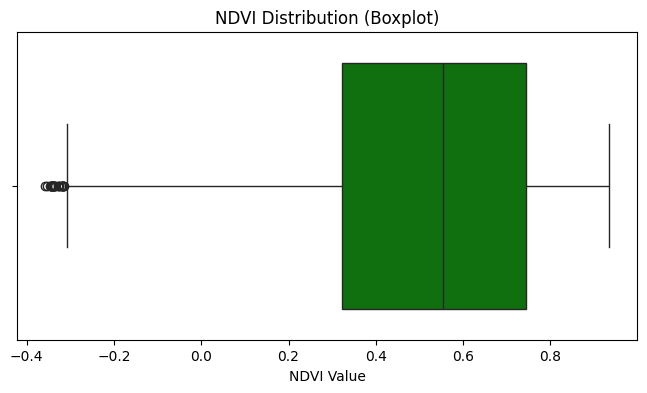

In [23]:
print("--- NDVI Statistics and Distribution After Masking ---")
ndvi_stats_after_filtering = calculate_NDVI_Statistics(burn_region_fire_2023, median_ndvi_combined_masked, scale=100)
print(ndvi_stats_after_filtering)

print("\n--- NDVI Distribution Plot After Masking ---")
plot_NDVI_distribution(burn_region_fire_2023, median_ndvi_combined_masked, scale=100)

# Optional: Run for original NDVI for comparison
# print("\n--- NDVI Statistics and Distribution Before Masking ---")
# ndvi_stats_before_filtering = calculate_NDVI_Statistics(burn_region_fire_2023, median_ndvi_sentinel2, scale=100)
# print(ndvi_stats_before_filtering)
# print("\n--- NDVI Distribution Plot Before Masking ---")
# plot_NDVI_distribution(burn_region_fire_2023, median_ndvi_sentinel2, scale=100)

# Vegetation regeneration after bushfire in 2023
- https://www.bbc.com/news/world-europe-66295972
- https://greekcitytimes.com/2023/08/29/over-800000-acres-burned-evros/



In [24]:
list_of_measurement_point_dates = ["2023-07-13", "2023-07-21", "2023-10-04", "2023-10-11", "2024-08-27", "2024-09-01", "2025-07-21", "2025-07-30"]
satellite_images = []
date = 0
while date < len(list_of_measurement_point_dates)-1:
  start_date = list_of_measurement_point_dates[date]
  end_date = list_of_measurement_point_dates[date+1]

  satellite_images.append(Sentinel2_Satellite_Imagery(burn_region_fire_2023,start_date,end_date,10))

  print(f"Date: {start_date} - {end_date} added to the list of satellite images\n")
  date = date + 2

#satellite_images

Found 5 Sentinel-2 images for the specified period
Date: 2023-07-13 - 2023-07-21 added to the list of satellite images

Found 3 Sentinel-2 images for the specified period
Date: 2023-10-04 - 2023-10-11 added to the list of satellite images

Found 1 Sentinel-2 images for the specified period
Date: 2024-08-27 - 2024-09-01 added to the list of satellite images

Found 8 Sentinel-2 images for the specified period
Date: 2025-07-21 - 2025-07-30 added to the list of satellite images



In [25]:
def calculate_and_apply_masks(satellite_image):
  """
  Calcualte NDWI and NDBI and apply masks.

  input: satellite image
  output: masked satellite image
  """

  try:
    # Calculate NDWI and create water mask
    image_with_ndwi = calculate_ndwi(first_image)
    water_mask_ndwi = create_water_mask_from_ndwi(image_with_ndwi)

    # Calculate NDBI and create urban mask
    image_with_ndbi = calculate_ndbi(first_image)
    # You might need to adjust the threshold based on your area and image characteristics
    urban_mask_ndbi = create_urban_mask_from_ndbi(image_with_ndbi, threshold=0.1) # Example threshold

    # Combine the masks: Add the water mask and urban mask.
    # Pixels that are either water (mask_ndwi=1) or urban (urban_mask_ndbi=1) will have a value >= 1.
    # We then create a combined mask where the value is 1 if it's either water or urban.
    combined_mask = water_mask_ndwi.add(urban_mask_ndbi).gt(0).rename('combined_mask')

    # Apply the combined mask to the median NDVI image
    # We update the mask where combined_mask is 0 (meaning it's neither water nor urban)
    median_ndvi_combined_masked = median_ndvi_sentinel2.updateMask(combined_mask.eq(0))
    print("✓ Masks applied successfully")
    return median_ndvi_combined_masked

  except Exception as e:
    print(f"⚠️ An error occurred while applying masks: {e}")
    return None

In [26]:
stat_after_filtering = []
for image_collection in satellite_images:
    if image_collection is not None and image_collection.size().getInfo() > 0:
        try:
            # 1. Calculate the median NDVI for the current image collection (time period)
            ndvi_collection = image_collection.map(calculate_ndvi_on_Sentinel2)
            median_ndvi_current = ndvi_collection.select('NDVI').median().clip(burn_region_fire_2023)

            # 2. Get a representative image from the collection to calculate masks (e.g., the first image)
            # Using the first image from the collection for the current time period to calculate masks
            representative_image = image_collection.first()

            # 3. Calculate NDWI and urban masks for the current time period
            image_with_ndwi = calculate_ndwi(representative_image)
            water_mask_ndwi = create_water_mask_from_ndwi(image_with_ndwi)

            image_with_ndbi = calculate_ndbi(representative_image)
            # Adjust threshold as needed
            urban_mask_ndbi = create_urban_mask_from_ndbi(image_with_ndbi, threshold=0.1)

            # Combine the masks
            combined_mask = water_mask_ndwi.add(urban_mask_ndbi).gt(0).rename('combined_mask')

            # 4. Apply the combined mask to the median NDVI for the current time period
            median_ndvi_combined_masked_current = median_ndvi_current.updateMask(combined_mask.eq(0))
            print(f"✓ Masks applied and median NDVI calculated for a time period")

            # 5. Calculate statistics for the masked median NDVI
            ndvi_stats_after_filtering_current = calculate_NDVI_Statistics(
                burn_region_fire_2023,
                median_ndvi_combined_masked_current,
                scale=100
            )
            stat_after_filtering.append(ndvi_stats_after_filtering_current)

        except Exception as e:
            print(f"⚠️ An error occurred while processing a time period: {e}")
            stat_after_filtering.append(None) # Append None if processing fails for a period
    else:
        print("⚠️ No images found for a time period, appending None for statistics.")
        stat_after_filtering.append(None)


print("\nLength of stat list", len(stat_after_filtering))
print(stat_after_filtering)

# After recalculating stat_after_filtering, rerun the plotting cell (yhOErbJzECJj)

✓ Masks applied and median NDVI calculated for a time period
📊 NDVI Statistics for the area calculated!
✓ Masks applied and median NDVI calculated for a time period
📊 NDVI Statistics for the area calculated!
✓ Masks applied and median NDVI calculated for a time period
📊 NDVI Statistics for the area calculated!
✓ Masks applied and median NDVI calculated for a time period
📊 NDVI Statistics for the area calculated!

Length of stat list 4
[{'NDVI_min': -0.027574503794312477, 'NDVI_max': 0.9000348448753357, 'NDVI_mean': 0.5914690300833348, 'NDVI_std': None, 'NDVI_count': 200165}, {'NDVI_min': -0.07407407462596893, 'NDVI_max': 0.951968789100647, 'NDVI_mean': 0.46796581190515657, 'NDVI_std': None, 'NDVI_count': 97964}, {'NDVI_min': -0.04668558016419411, 'NDVI_max': 0.937552273273468, 'NDVI_mean': 0.4599662512929421, 'NDVI_std': None, 'NDVI_count': 179913}, {'NDVI_min': -0.025641025975346565, 'NDVI_max': 0.9572147727012634, 'NDVI_mean': 0.5172803632354047, 'NDVI_std': None, 'NDVI_count': 13699

In [27]:
import plotly.express as px
import pandas as pd

# Extract the mean, min, and max NDVI values from the list of statistics
mean_ndvi_values = [stats['NDVI_mean'] for stats in stat_after_filtering if stats is not None]
min_ndvi_values = [stats['NDVI_min'] for stats in stat_after_filtering if stats is not None]
max_ndvi_values = [stats['NDVI_max'] for stats in stat_after_filtering if stats is not None]


# Extract the corresponding dates for the x-axis and convert to datetime objects
# Use every second date from list_of_measurement_point_dates, corresponding to the start dates
# of the intervals used to generate stat_after_filtering.
plot_date_strings = list_of_measurement_point_dates[::2][:len(stat_after_filtering)] # Take every second date, limit to the number of stats
plot_dates = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in plot_date_strings]


# Check if the number of values matches the number of dates for all lists
if len(mean_ndvi_values) == len(plot_dates) and len(min_ndvi_values) == len(plot_dates) and len(max_ndvi_values) == len(plot_dates):
    # Create a pandas DataFrame for Plotly
    df = pd.DataFrame({
        'Date': plot_dates,
        'Mean NDVI': mean_ndvi_values,
        'Min NDVI': min_ndvi_values,
        'Max NDVI': max_ndvi_values
    })

    # Create interactive line plot using Plotly Express
    fig = px.line(df, x='Date', y=['Mean NDVI', 'Min NDVI', 'Max NDVI'],
                  title='Mean, Min, and Max NDVI Over Time (After Masking)')

    # Add vertical shaded region for the fire period
    fire_start_date_str = '2023-08-21'
    fire_end_date_str = '2023-08-28'
    fire_start_date = datetime.strptime(fire_start_date_str, '%Y-%m-%d')
    fire_end_date = datetime.strptime(fire_end_date_str, '%Y-%m-%d')

    fig.add_vrect(x0=fire_start_date, x1=fire_end_date,
                  fillcolor="red", opacity=0.3, line_width=0, annotation_text="Bushfire Period", annotation_position="top left")


    fig.show()

else:
    print("⚠️ The number of NDVI values does not match the number of dates for one or more lists. Cannot create plot.")
    print(f"Number of mean values: {len(mean_ndvi_values)}")
    print(f"Number of min values: {len(min_ndvi_values)}")
    print(f"Number of max values: {len(max_ndvi_values)}")
    print(f"Number of dates: {len(plot_dates)}")